{
    "nodes": [
        {
            "id": "acctbal",
            "label": "acctbal"
        },
        {
            "id": "name",
            "label": "name"
        },
        {
            "id": "order_date",
            "label": "order_date"
        },
        {
            "id": "orders",
            "label": "orders"
        }
    ],
    "edges": [
        {
            "source": "acctbal",
            "target": "name"
        },
        {
            "source": "acctbal",
            "target": "order_date"
        },
        {
            "source": "acctbal",
            "target": "orders"
        },
        {
            "source": "name",
            "target": "order_date"
        },
        {
            "source": "name",
            "target": "orders"
        },
        {
            "source": "order_date",
            "target": "orders"
        }
    ]
}


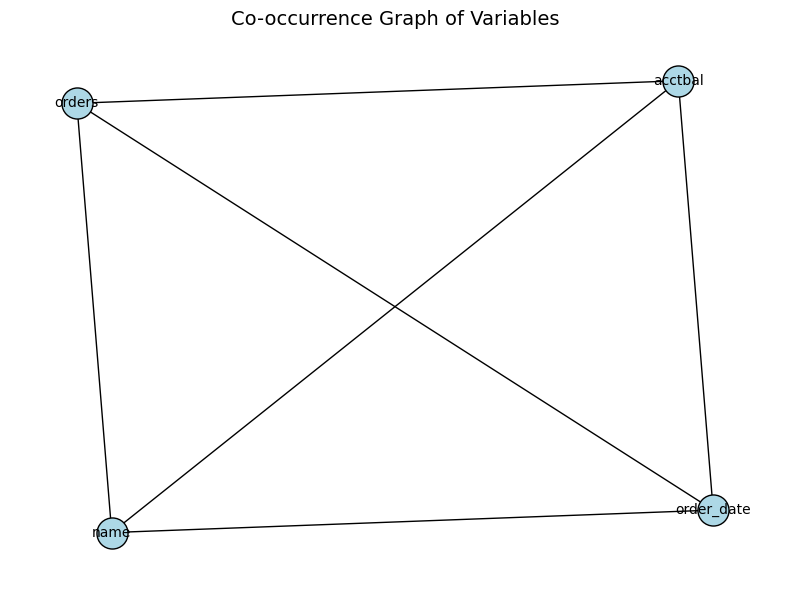

In [1]:
import ast
import json
from itertools import combinations
import networkx as nx
import matplotlib.pyplot as plt

class VariableNameExtractor(ast.NodeVisitor):
    def __init__(self):
        self.names = set()
    def visit_Name(self, node):
        # Ignore uppercase identifiers (like COUNT or YEAR)
        if not node.id.isupper():
            self.names.add(node.id)
        self.generic_visit(node)

def extract_calculate_rhs_names(code):
    """
    Parse a DSL snippet and extract variable names from the right-hand side of CALCULATE keyword assignments.
    """
    tree = ast.parse(code)
    names = set()
    for node in ast.walk(tree):
        if (
            isinstance(node, ast.Call)
            and isinstance(node.func, ast.Attribute)
            and node.func.attr == "CALCULATE"
        ):
            for kw in node.keywords:
                extractor = VariableNameExtractor()
                extractor.visit(kw.value)
                names.update(extractor.names)
    return names

def build_graph_from_snippets(snippets):
    """
    Build a co-occurrence graph where each variable (from CALCULATE calls) is a node,
    and an edge connects any two variables that appear together in a snippet.
    """
    all_nodes = set()
    snippet_vars = []  # list of sets of variable names per snippet
    for code in snippets:
        vars_in_snippet = extract_calculate_rhs_names(code)
        snippet_vars.append(vars_in_snippet)
        all_nodes.update(vars_in_snippet)
        
    nodes = [{"id": var, "label": var} for var in sorted(all_nodes)]
    edges = []
    added_edges = set()
    for vars_in_snippet in snippet_vars:
        for a, b in combinations(sorted(vars_in_snippet), 2):
            key = tuple(sorted((a, b)))
            if key not in added_edges:
                added_edges.add(key)
                edges.append({"source": key[0], "target": key[1]})
    return {"nodes": nodes, "edges": edges}

def visualize_graph(graph):
    """
    Visualize the graph using NetworkX and Matplotlib.
    """
    G = nx.Graph()
    # Add nodes and edges from our graph data
    for node in graph["nodes"]:
        G.add_node(node["id"])
    for edge in graph["edges"]:
        G.add_edge(edge["source"], edge["target"])
    
    # Use spring layout for a visually appealing graph
    pos = nx.spring_layout(G)
    
    plt.figure(figsize=(8, 6))
    nx.draw_networkx_nodes(G, pos, node_size=500, node_color="lightblue", edgecolors="black")
    nx.draw_networkx_edges(G, pos)
    nx.draw_networkx_labels(G, pos, font_size=10)
    
    plt.title("Co-occurrence Graph of Variables", fontsize=14)
    plt.axis("off")
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    snippet1 = '''# Find all suppliers from the United States
us_suppliers = suppliers.WHERE(nation.name == "UNITED STATES").CALCULATE(
    supplier_name=name
)
'''
    snippet2 = '''# First, identify orders placed in 1995
orders_1995 = orders.WHERE(YEAR(order_date) == 1995)

# Find European customers with account balance > $700 who placed at least one order in 1995
european_customers = customers.CALCULATE(
    customer_name=name,
    account_balance=acctbal,
    num_orders_1995=COUNT(orders.WHERE(YEAR(order_date) == 1995))
).WHERE(
    (nation.region.name == "EUROPE") &
    (acctbal > 700) &
    (num_orders_1995 > 0)
).ORDER_BY(
    num_orders_1995.DESC()
)
'''

    snippets = [snippet1, snippet2]
    graph = build_graph_from_snippets(snippets)
    # Output JSON structure of the graph
    print(json.dumps(graph, indent=4))
    # Visualize the graph
    visualize_graph(graph)
